In [152]:
import json
import os
import sys
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("talk")
sns.set_style('white')
import numpy as np
import operator
from IPython.display import display as disp, HTML

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
import profiler
import single_model_profiles as sm_profs
from single_model_profiles import create_model_profile_df as create_df
import end_to_end_profiles as e2e_profiles
from utils import COST_PER_GPU, COST_PER_CPU
from end_to_end_profiles import load_end_to_end_experiment as load_e2e


In [119]:
COST_PER_CPU, COST_PER_GPU

(0.0475, 0.7)

## Load Results

In [59]:
tf_results = e2e_profiles.load_tfserving_end_to_end("image_driver_1")
single_proc_results = e2e_profiles.load_pipeline_one_single_proc()
paths = {
    "Latency Greedy": "../results/e2e_profs/systemx/image_driver_1/min_latency",
    "Throughput Greedy": "../results/e2e_profs/systemx/image_driver_1/max_throughput",
    "500ms SLO": "../results/e2e_profs/systemx/image_driver_1/500ms",
    "1000ms SLO": "../results/e2e_profs/systemx/image_driver_1/1000ms"    
}

dfs = []
for name, path in paths.items():
    dfs.append(e2e_profiles.load_end_to_end_experiment(name, path)[0])
system_x_results = pd.concat(dfs)

In [ ]:
def plot_cost_comp(sys_x, spd):
    plt.clf()
    fig, ax_thru = plt.subplots(nrows=1, ncols=1, figsize=(11,7))
#     colors = sns.color_palette()
    markers = {
        "Latency Greedy": "s",
        "Throughput Greedy": "o",
        "500ms SLO": "v",
        "1000ms SLO": "d"
    }
    
    def plot_system_x():
        colors = sns.color_palette("Blues_d", n_colors=3)
        # Plot the System X results
        for exp in ["Latency Greedy", "500ms SLO", "1000ms SLO"]:
            c = colors.pop()
            df = sys_x[(sys_x.name == exp)]
            df = df.sort_values('cost')
            m = markers[exp]
            ax_thru.errorbar(df["mean_throughput"], df['cost'], xerr=df["standard_dev_throughput"], label="InferLine {}".format(exp), marker=m, color=c)
#             ax_lat.plot(df['p99_latency'], df["cost"], linestyle="--", color=c, marker=m, label="{}_p99".format(exp))
#             ax_lat.plot(df['p95_latency'], df["cost"], linestyle="-", color=c, marker=m, label="{}_p95".format(exp))
    
    def plot_spd():
        colors = sns.color_palette("Oranges", n_colors=1)
        for exp in ["Latency Greedy"]:
            c = colors.pop()
            df = spd[(spd.name == exp)]
            df = df.sort_values('cost')
            m = markers[exp]
            ax_thru.plot(df["mean_throughput"], df['cost'], label="SPD {}".format(exp), marker=m, color=c)
#             ax_lat.plot(df['p99_latency'], df["cost"], linestyle="--", color=c, marker=m, label="{}_p99".format(exp))
    
    plot_system_x()
    plot_spd()
    ax_thru.set_xlabel("Throughput (qps)")
    ax_thru.set_ylabel("Cost ($/hr)")
#     ax_lat.set_xlabel("Latency (s)")
#     ax_lat.set_ylabel("Cost ($/hr)")
#     ax_lat.set_ticks(np.arange(0.0, 6.0, 0.5))
#     ax_thru.legend()
#     ax_lat.legend()
    plt.show
    plt.savefig(os.path.expanduser("~/Desktop/winter_retreat_2018_plots/thru_vs_cost.png"))
plot_cost_comp(system_x_results, single_proc_results)

(1.5367499999999998, 6.8882499999999993)


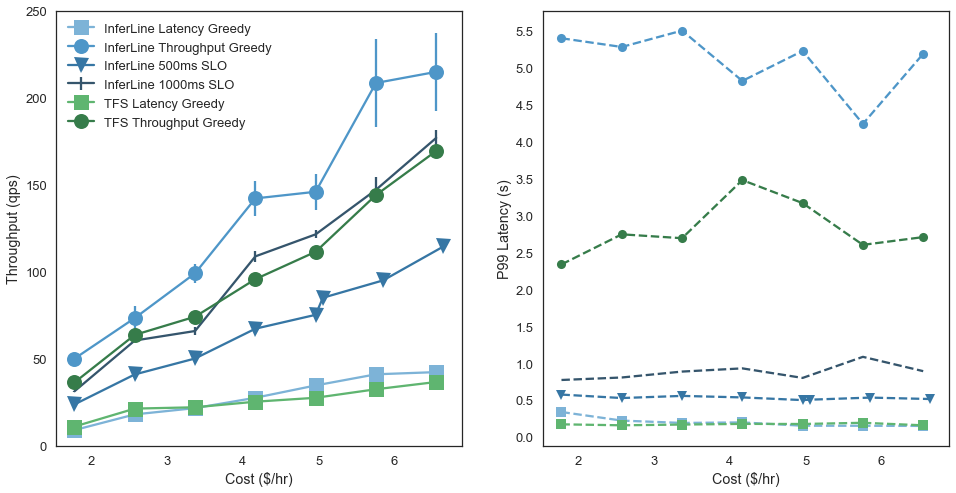

In [111]:
def plot_sys_comp(sys_x, tfs, spd):
    plt.clf()
    fig, (ax_thru, ax_lat) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
#     colors = sns.color_palette()
    colors = sns.color_palette("Set2", n_colors=8)
    markers = {
        "Latency Greedy": "s",
        "Throughput Greedy": "o",
        "500ms SLO": "v",
        "1000ms SLO": "+"
    }
    
    def plot_system_x(exps):
        colors = sns.color_palette("Blues_d", n_colors=4)
        # Plot the System X results
        for exp, display in exps.items():
            c = colors.pop()
            df = sys_x[(sys_x.name == exp)]
            df = df.sort_values('cost')
            m = markers[exp]
            if display:
                ax_thru.errorbar(df['cost'], df["mean_throughput"], yerr=df["standard_dev_throughput"], label="InferLine {}".format(exp),
                                 marker=m, color=c, markersize=15)
                ax_lat.plot(df["cost"], df['p99_latency'], linestyle="--", color=c, marker=m, label="InferLine {} P99".format(exp))
#                 ax_lat.plot(df["cost"], df['p95_latency'], linestyle="-", color=c, marker=m, label="{}_p95".format(exp))
    
    def plot_tf_serving(exps):
        colors = sns.color_palette("Greens_d", n_colors=2)
        for exp, display in exps.items():
            c = colors.pop()
            df = tfs[(tfs.name == exp)]
            df = df.sort_values('cost')
            m = markers[exp]
            if display:
                ax_thru.errorbar(df['cost'], df["mean_throughput"], yerr=df["standard_dev_throughput"], label="TFS {}".format(exp),
                                 marker=m, color=c, markersize=15)
                ax_lat.plot(df["cost"], df['p99_latency'], linestyle="--", color=c, marker=m, label="{}_p99".format(exp))
#                 ax_lat.plot(df["cost"], df['p95_latency'], linestyle="-", color=c, marker=m, label="{}_p95".format(exp))
    
    def plot_spd(exps):
        colors = sns.color_palette("Oranges", n_colors=2)
        for exp, display in exps.items():
            c = colors.pop()
            df = spd[(spd.name == exp)]
            df = df.sort_values('cost')
            m = markers[exp]
            if display:
                ax_thru.plot(df['cost'], df["mean_throughput"], label="SPD {}".format(exp), marker=m, color=c, markersize=15)
                ax_lat.plot(df["cost"], df['p99_latency'], linestyle="--", color=c, marker=m, label="SPD {} P99".format(exp))

    
#     plot_system_x(["Latency Greedy", "Throughput Greedy", "500ms SLO", "1000ms SLO"])
    plot_system_x({"Latency Greedy": True, "Throughput Greedy": True, "500ms SLO": True, "1000ms SLO": True})
    plot_tf_serving({"Latency Greedy": True, "Throughput Greedy": True})
#     plot_spd({"Latency Greedy": True, "Throughput Greedy": True})
    def plot_slo(slo):
        slo_xs = ax_lat.get_xlim()
        print(slo_xs)
        ax_lat.plot(slo_xs, np.ones(len(slo_xs))*slo, color="k", linestyle=":")
#     plot_slo(0.5)
    ax_thru.set_ylabel("Throughput (qps)")
    ax_thru.set_xlabel("Cost ($/hr)")
    ax_lat.set_ylabel("P99 Latency (s)")
    ax_lat.set_xlabel("Cost ($/hr)")
    ax_lat.set_yticks(np.arange(0.0, 6.0, 0.5))
#     ax_lat.set_yticks(np.arange(0.0, 2.0, 0.3))

    ax_thru.set_ylim([0, 250])
    print(ax_lat.get_xlim())
    ax_thru.legend(ncol=1, loc=0)
#     ax_lat.legend(ncol=1, loc=0)
    plt.savefig(os.path.expanduser("~/Desktop/winter_retreat_2018_plots/tfs_vs_ifl_poster.png"), bbox_inches='tight')
    plt.show()

    
    
plot_sys_comp(system_x_results, tf_results, single_proc_results)

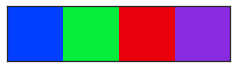

In [145]:
sns.palplot(sns.color_palette("bright", n_colors=4))
colors = 

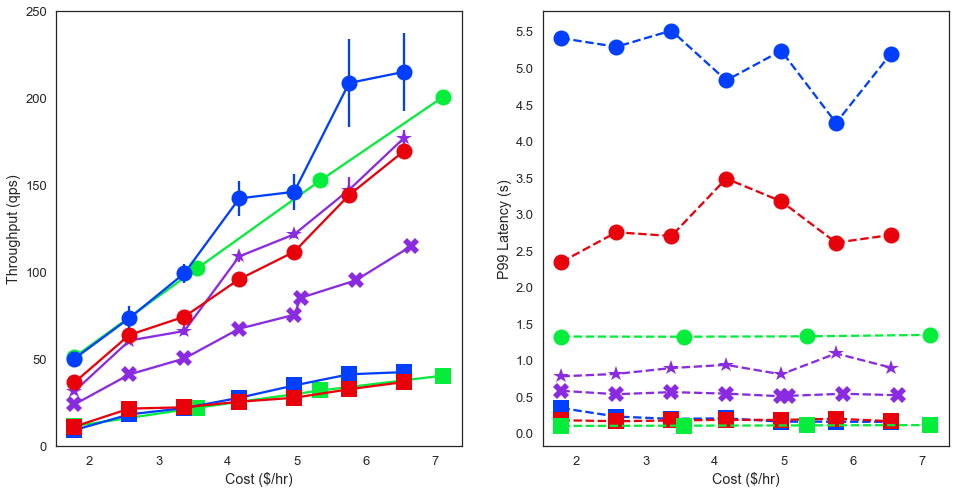

In [186]:
def plot_sys_comp(sys_x, tfs, spd):
    plt.clf()
    fig, (ax_thru, ax_lat) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
    lines = []
    labels = []
#     fig, ax_thru = plt.subplots(nrows=1, ncols=1, figsize=(8,8))

#     colors = sns.color_palette()
    colors = sns.color_palette("bright", n_colors=4)
    markers = {
        "Latency Greedy": "s",
        "Throughput Greedy": "o",
        "500ms SLO": "X",
        "1000ms SLO": "*"
    }
    ms = 16
    
    def plot_system_x(exps):
        c = colors[0]
        # Plot the System X results
        for exp, display in exps.items():
            df = sys_x[(sys_x.name == exp)]
            df = df.sort_values('cost')
            m = markers[exp]
            if exp == "500ms SLO" or exp == "1000ms SLO":
                c = colors[3]
            if display:
#                 disp(df)
                lines.append(
                ax_thru.errorbar(df['cost'], df["mean_throughput"], yerr=df["standard_dev_throughput"], label="InferLine {}".format(exp),
                                 marker=m, color=c, markersize=ms))
                labels.append("InferLine {}".format(exp))

                ax_lat.plot(df["cost"], df['p99_latency'], linestyle="--", color=c, marker=m, markersize=ms, label="InferLine {} P99".format(exp))
#                 ax_lat.plot(df["cost"], df['p95_latency'], linestyle="-", color=c, marker=m, label="{}_p95".format(exp))
    
    def plot_tf_serving(exps):
        c = colors[2]
        for exp, display in exps.items():
            df = tfs[(tfs.name == exp)]
            df = df.sort_values('cost')

            m = markers[exp]
            if display:
#                 disp(df)
                lines.append(
                ax_thru.errorbar(df['cost'], df["mean_throughput"], yerr=df["standard_dev_throughput"], label="TFS {}".format(exp),
                                 marker=m, color=c, markersize=ms))
                labels.append("TFS {}".format(exp))
                ax_lat.plot(df["cost"], df['p99_latency'], linestyle="--", color=c, marker=m, markersize=ms, label="{}_p99".format(exp))
#                 ax_lat.plot(df["cost"], df['p95_latency'], linestyle="-", color=c, marker=m, label="{}_p95".format(exp))
    
    def plot_spd(exps):
        c = colors[1]
        for exp, display in exps.items():
            df = spd[(spd.name == exp)]
            df = df.sort_values('cost')

            m = markers[exp]
            if display:
#                 disp(df)
                lines.append(
                ax_thru.plot(df['cost'], df["mean_throughput"], label="SPD {}".format(exp),
                             marker=m, color=c, markersize=ms))
                labels.append("SPD {}".format(exp))
                ax_lat.plot(df["cost"], df['p99_latency'], linestyle="--", color=c, marker=m, markersize=ms, label="SPD {} P99".format(exp))

    
    plot_system_x({"Latency Greedy": True, "Throughput Greedy": True, "500ms SLO": True, "1000ms SLO": True})
    plot_tf_serving({"Latency Greedy": True, "Throughput Greedy": True})
    plot_spd({"Latency Greedy": True, "Throughput Greedy": True})
    def plot_slo(slo):
        slo_xs = ax_lat.get_xlim()
        print(slo_xs)
        ax_lat.plot(slo_xs, np.ones(len(slo_xs))*slo, color="k", linestyle=":")
#     plot_slo(0.5)
    ax_thru.set_ylabel("Throughput (qps)")
    ax_thru.set_xlabel("Cost ($/hr)")
    ax_lat.set_ylabel("P99 Latency (s)")
    ax_lat.set_xlabel("Cost ($/hr)")
    ax_lat.set_yticks(np.arange(0.0, 6.0, 0.5))
    ax_thru.set_ylim((-2.4555670656128754, 248.8846915936893))
    ax_thru.set_xlim((1.5129999999999999, 7.3869999999999996))
    ax_lat.set_ylim((-0.17653428806249996, 5.7774861318124993))
    ax_lat.set_xlim((1.5129999999999999, 7.3869999999999996))

#     ax_lat.set_yticks(np.arange(0.0, 2.0, 0.3))

    ax_thru.set_ylim([0, 250])
    fig.savefig(os.path.expanduser("~/Desktop/winter_retreat_2018_plots/sys-comp-5.pdf"), bbox_inches='tight')

    fl = plt.figure(figsize=(3,2))
    fl.legend(*ax_thru.get_legend_handles_labels(), loc = 'center', frameon=False)
    fl.savefig(os.path.expanduser("~/Desktop/winter_retreat_2018_plots/sys_comp_legend-5.pdf"))
    plt.show()
#     figlegend.show()

    
    
plot_sys_comp(system_x_results, tf_results, single_proc_results)

In [ ]:
system_x_results

In [ ]:
tf_results

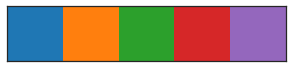

In [130]:
sns.palplot(sns.color_palette(n_colors=5))

## Single Model Perf Heterogeneity

In [160]:
profs = sm_profs.load_single_model_profiles()

(-2.7810096153846153, 80.401201923076925)
(-3.4982116087534738, 230.74540662142903)


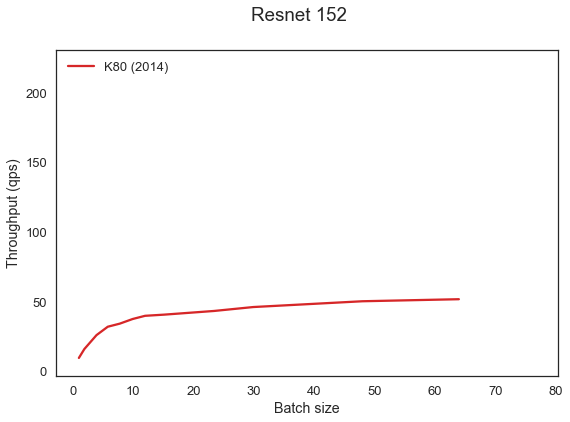

In [163]:
sns.set_context("talk")
sns.set_style('white')
def plot_smp_thrus(prof, title, plot_gcp=False, plot_aws=False):
    # GCP
    label_map = {"k80": "K80 (2014)",
                 "p100": "P100 (2016)",
                 "v100": "V100 (2017)"
                }
    
    plt.clf()
#     fig, (ax_thru, ax_lat) = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
    fig, ax_thru = plt.subplots(nrows=1, ncols=1, figsize=(9,6))

    dfs = []
    colors = sns.color_palette(n_colors=5)
    if plot_gcp:
        gcp_profs = prof[(prof.cloud == "gcp")]
        for gpu in ["p100"]:
            for num_cpus in [2]:
                df = gcp_profs[(gcp_profs.gpu_type == gpu)
                             & (gcp_profs.num_cpus_per_replica == num_cpus)]
                df = df.sort_values("mean_batch_size")
#                 c = colors.pop()
                c = colors[4]
                ax_thru.plot(df["mean_batch_size"], df["mean_throughput_qps"], color=c, label="{gpu}".format(gpu=label_map[gpu], cpu=num_cpus))
#                 ax_lat.plot(df["mean_batch_size"], df["p99_latency"], color=c, label="{gpu}".format(gpu=label_map[gpu], cpu=num_cpus))

                dfs.append(df)
    if plot_aws:
        aws_profs = prof[(prof.cloud == "aws")]
#         for gpu in ["k80", "v100"]:
        for gpu in ["k80"]:
            for num_cpus in [2]:
                if gpu == "k80":
                    c = colors[3]
                elif gpu == "v100":
                    c = colors[2]
                df = aws_profs[(aws_profs.gpu_type == gpu)
                              & (aws_profs.num_cpus_per_replica == num_cpus)]
                df = df.sort_values("mean_batch_size")
                ax_thru.plot(df["mean_batch_size"], df["mean_throughput_qps"], color=c, label="{gpu}".format(gpu=label_map[gpu], cpu=num_cpus))
#                 ax_lat.plot(df["mean_batch_size"], df["p99_latency"], color=c, label="{gpu}".format(gpu=label_map[gpu], cpu=num_cpus))
                dfs.append(df)


    def make_legend(ax):
        handles, labels = ax.get_legend_handles_labels()
    
        hl = sorted(zip(handles, labels),
            key=operator.itemgetter(1))
        handles2, labels2 = zip(*hl)

        ax.legend(handles2, labels2, loc=2)
        
    ax_thru.set_xlabel("Batch size")
    ax_thru.set_ylabel("Throughput (qps)")
    ax_thru.set_ylim((-3.4982116087534738, 230.74540662142903))
    ax_thru.set_xlim((-2.7810096153846153, 80.401201923076925))
#     ax_thru.set_xlim(left=-10)
    make_legend(ax_thru)
#     ax_lat.set_xlabel("Batch size")
#     ax_lat.set_ylabel("p99 latency (s)")
#     make_legend(ax_lat)
    fig.suptitle(title)
    plt.savefig(os.path.expanduser("~/Desktop/winter_retreat_2018_plots/smp_gpu_heterogeneity_thru_only-k80.pdf"))
    print(ax_thru.get_xlim())
    print(ax_thru.get_ylim())
    
#     fig.show()
    return dfs
            
dfs = plot_smp_thrus(profs["tf-resnet-feats"], "Resnet 152", plot_gcp=False, plot_aws=True)

In [114]:
for df in dfs:
    display(df.sort_values('mean_batch_size'))

,num_cpus_per_replica,mean_throughput_qps,std_throughput_qps,p99_latency,mean_batch_size,cost,fname,cloud,gpu_type
0,2,9.252572,0.000473,0.119576,1.000000,0.795,results-171124_095337.json,aws,k80
1,2,15.658447,0.041688,0.361880,1.909714,0.795,results-171124_095909.json,aws,k80
2,2,25.644877,0.083090,0.477645,3.919207,0.795,results-171124_100707.json,aws,k80
3,2,31.679496,0.315383,0.549972,5.788047,0.795,results-171124_101354.json,aws,k80
4,2,33.885403,0.515985,0.689307,7.771930,0.795,results-171124_102021.json,aws,k80
5,2,37.219310,0.542419,0.803683,9.907097,0.795,results-171124_102704.json,aws,k80
6,2,39.519062,0.153764,0.935984,11.968000,0.795,results-171124_103408.json,aws,k80
7,2,40.359255,0.890720,1.144022,15.142105,0.795,results-171124_104258.json,aws,k80
8,2,42.993464,0.183316,1.615898,23.384615,0.795,results-171124_105004.json,aws,k80
9,2,45.814550,1.695242,1.942180,29.890909,0.795,results-171124_105817.json,aws,k80


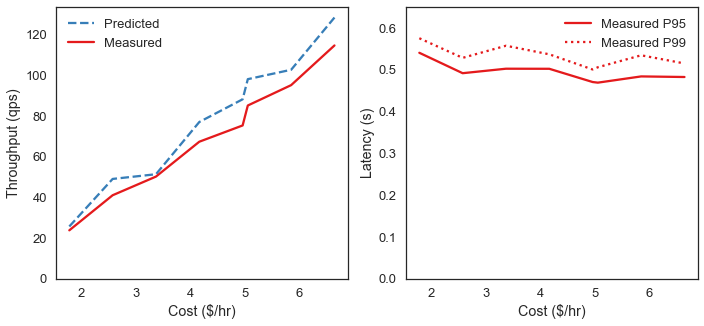

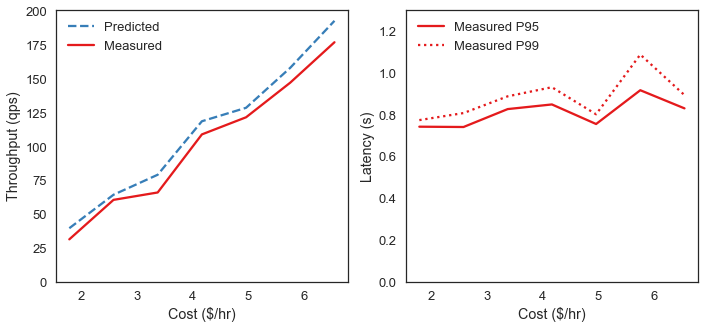

In [153]:

def filter_smp(df):
    df = df[(df.gpu_type == "k80")
                             & (df.cloud == "aws")]
    return df

def config_value(cost, throughput):
    return float(throughput) / float(cost)

def find_optimal_batch_config(df, slo=None):
    slim_df = df[["mean_batch_size", "mean_throughput_qps", "cost", "p99_latency"]]
    best_config = None
    best_value = 0
    for idx, row in slim_df.iterrows():
        batch_size = row["mean_batch_size"]
        throughput = row["mean_throughput_qps"]
        cost = row["cost"]
        latency = row["p99_latency"]
        value = config_value(cost, throughput)
        if value > best_value and ((slo == None) or (latency <= slo)):
            best_config = (batch_size, throughput, latency)
            best_value = value
    return best_config

def get_configs(branches, slo=None):
    all_configs = {}
    for branch in branches:
        branch_configs = branch_helper(branch, slo_budget=slo)
        for config in branch_configs:
            all_configs = all_configs.copy()
            all_configs.update(config)
        
    return all_configs
                    
def branch_helper(branch, slo_budget):
    branch = list(branch)
    model_name, model_df = branch.pop(0)
    if len(branch) == 0:
        optimal_config = find_optimal_batch_config(model_df, slo=slo_budget)
        if not optimal_config:
            return None
        else:
            return [{model_name : optimal_config}]
    else:
        while True:
            optimal_config = find_optimal_batch_config(model_df, slo=slo_budget)
            batch_size, throughput, latency = optimal_config
            if not optimal_config:
                return None
            else:
                if slo_budget:
                    new_budget = slo_budget - latency
                else:
                    new_budget = slo_budget
                next_configs = branch_helper(branch, new_budget)
                if next_configs:
                    return [{model_name : optimal_config}] + next_configs
                else:
                    # Configuration was bad, try another
                    model_df = model_df[model_df.mean_batch_size != batch_size]
                    print(model_df)   
                    
def get_min_lat_configs(branches):
    all_models = []
    for branch in branches:
        all_models = all_models + branch
        
    all_configs = {}
    while len(all_models) > 0:
        model_name, model_df = all_models.pop()
        min_df = model_df[model_df.mean_batch_size == 1.0]
        min_df = min_df[["mean_throughput_qps", "p99_latency"]]
        for idx, row in min_df.iterrows():
            throughput = row["mean_throughput_qps"]
            latency = row["p99_latency"]
            all_configs[model_name] = (1.0, throughput, latency)
            break
        
    return all_configs

def get_replications(gpu_configs, cpu_configs, num_gpus=8):
    
    def get_bottleneck_model(reps, configs):
        bottleneck_model_name = None
        bottleneck_throughput = None
        for model_name, config in configs.items():
            _, model_throughput, _ = config
            total_throughput = reps[model_name] * model_throughput
            if not bottleneck_throughput or total_throughput < bottleneck_throughput:
                bottleneck_model_name = model_name
                bottleneck_throughput = total_throughput
                
        return bottleneck_model_name, bottleneck_throughput
        
    
    all_configs = gpu_configs.copy()
    all_configs.update(cpu_configs)
    
    curr_reps = {}
    for model_name, _ in all_configs.items():
        curr_reps[model_name] = 1
        if model_name in gpu_configs:
            num_gpus -= 1
        
    all_reps = []
        
    while True:
        bottleneck_model_name, bottleneck_throughput = get_bottleneck_model(curr_reps, all_configs)
        if bottleneck_model_name in gpu_configs:
            if num_gpus == 0:
                break
            else:
                num_gpus -= 1
                
        all_reps.append((curr_reps.copy(), bottleneck_throughput))
        curr_reps[bottleneck_model_name] = curr_reps[bottleneck_model_name] + 1
        
    all_reps.append((curr_reps.copy(), bottleneck_throughput))
    
    return all_reps


def get_thrus_costs(gpu_configs, reps):
    costs = []
    thrus = []
    for rep_config, throughput in reps:
        total_cost = 0
        for model_name, num_reps in rep_config.items():
            cost = num_reps * COST_PER_CPU
            if model_name in gpu_configs:
                cost += num_reps * COST_PER_GPU
            total_cost += cost

        costs.append(total_cost)
        thrus.append(throughput)

    return thrus, costs

def get_e2e_thrus_costs(e2e_df):
    thrus = []
    costs = []
    slim_df = e2e_df[["mean_throughput", "cost"]].sort_values("cost")
    for idx, row in slim_df.iterrows():
        thru = row["mean_throughput"]
        cost = row["cost"]
        thrus.append(thru)
        costs.append(cost)
        
    return thrus, costs

def get_latency_stats(df):
    p95s = []
    p99s = []
    costs = []
    for idx, row in df.sort_values("cost").iterrows():
        lats = row["latency"]
        lats = lats.flatten()
        p99s.append(np.percentile(lats, 99))
        p95s.append(np.percentile(lats, 95))
        cost = row["cost"]
        costs.append(cost)
    return costs, p99s, p95s

def plot_diff(costs, pred_thru, emp_thru, emp_p99, emp_p95, slo, fname):
#     diffs = np.array(e2e_max_thru_thrus) - np.array(max_thru_thrus)
#     print("Percentage differences (relative to expectation): {}".format(diffs / max_thru_thrus))
    plt.clf()
    colors = sns.color_palette("Set1", n_colors=2)
    colors.reverse()
    fig, (ax_thru, ax_lat) = plt.subplots(nrows=1, ncols=2, figsize=(11.5,5))
    ax_thru.plot(costs, pred_thru, linestyle='--', color=colors[0], label="Predicted")
    ax_thru.plot(costs, emp_thru, linestyle='-', color=colors[1], label="Measured")
    ax_lat.plot(costs, emp_p95, linestyle="-", color=colors[1], label="Measured P95")
    ax_lat.plot(costs, emp_p99, linestyle=":", color=colors[1], label="Measured P99")
#     ax_lat.plot(ax_lat.get_xlim(), np.ones(len(ax_lat.get_xlim()))*slo, linestyle="--", color=colors[0], label="SLO")
    ax_lat.set_xlabel("Cost ($/hr)")
    ax_thru.set_xlabel("Cost ($/hr)")
    ax_lat.set_ylabel("Latency (s)")
    ax_thru.set_ylabel("Throughput (qps)")
    ax_lat.set_ylim((0, slo*1.3))
    ax_thru.set_ylim(bottom=0)
    ax_thru.legend(loc=0)
    ax_lat.legend(loc=0)
    plt.savefig(fname)
    plt.show()
    

def get_predicted_perf(branches, slo=None):
    configs = get_configs(branches, slo=slo)
    gpu_configs = {k: configs[k] for k in ('inception', 'tf-resnet-feats')}
    cpu_configs = {k: configs[k] for k in ('tf-kernel-svm', 'tf-log-reg')}
    reps = get_replications(gpu_configs=gpu_configs, cpu_configs=cpu_configs, num_gpus=8)
    thrus, costs = get_thrus_costs(gpu_configs, reps)
    return costs, thrus

def get_empirical_perf(name, path):
    df = load_e2e(name, path)[0]
    thrus, thru_costs = get_e2e_thrus_costs(df)
    lat_costs, p99s, p95s = get_latency_stats(df)
    assert thru_costs == lat_costs
    return thru_costs, thrus, p99s, p95s

    
def plot_500ms(branches):
    emp_path = "../results/e2e_profs/systemx/image_driver_1/500ms"
    pred_costs, pred_thrus = get_predicted_perf(branches, slo=0.5)
    emp_costs, emp_thrus, p99s, p95s = get_empirical_perf("500ms", emp_path)
    fname = os.path.expanduser("~/Desktop/winter_retreat_2018_plots/pred_vs_emp_500ms.pdf")
    plot_diff(emp_costs, pred_thrus, emp_thrus, p99s, p95s, 0.5, fname)
    
def plot_1000ms(branches):
    emp_path = "../results/e2e_profs/systemx/image_driver_1/1000ms"
    pred_costs, pred_thrus = get_predicted_perf(branches, slo=1.0)
    emp_costs, emp_thrus, p99s, p95s = get_empirical_perf("1000ms", emp_path)
    fname = os.path.expanduser("~/Desktop/winter_retreat_2018_plots/pred_vs_emp_1000ms.pdf")
    plot_diff(emp_costs, pred_thrus, emp_thrus, p99s, p95s, 1.0, fname)
    
profs = sm_profs.load_single_model_profiles()
model_names = ["tf-resnet-feats", "inception", "tf-log-reg", "tf-kernel-svm"]
profs = {name:p for name, p in profs.items() if name in model_names}

profs["tf-resnet-feats"] = filter_smp(profs["tf-resnet-feats"])
profs["inception"] = filter_smp(profs["inception"])

configs = {name:find_optimal_batch_config(p) for name, p in profs.items()}

resnet_ksvm_branch = [("tf-resnet-feats", profs["tf-resnet-feats"]), ("tf-kernel-svm", profs["tf-kernel-svm"])]
inception_log_reg_branch = [("inception", profs["inception"]), ("tf-log-reg", profs["tf-log-reg"])]
branches = list([resnet_ksvm_branch, inception_log_reg_branch])

plot_500ms(branches)
plot_1000ms(branches)


# all_configs = get_configs(branches, slo=None)

# gpu_configs = {k: all_configs[k] for k in ('inception', 'tf-resnet-feats')}
# cpu_configs = {k: all_configs[k] for k in ('tf-kernel-svm', 'tf-log-reg')}



    

# half_second_configs = get_configs(list(branches), slo=.5)
# half_second_gpu_configs = {k: half_second_configs[k] for k in ('tf-inception', 'tf-resnet')}
# half_second_cpu_configs = {k: half_second_configs[k] for k in ('tf-ksvm', 'tf-log-reg')}
# half_second_reps = get_replications(gpu_configs=half_second_gpu_configs, cpu_configs=half_second_cpu_configs, num_gpus=8)

# one_second_configs = get_configs(list(branches), slo=1)
# one_second_gpu_configs = {k: one_second_configs[k] for k in ('tf-inception', 'tf-resnet')}
# one_second_cpu_configs = {k: one_second_configs[k] for k in ('tf-ksvm', 'tf-log-reg')}
# one_second_reps = get_replications(gpu_configs=one_second_gpu_configs, cpu_configs=one_second_cpu_configs, num_gpus=8)

# half_second_thrus, half_second_costs = get_thrus_costs(half_second_gpu_configs, half_second_reps)
# one_second_thrus, one_second_costs = get_thrus_costs(one_second_gpu_configs, one_second_reps)



    
    

# half_second_relative_path = "../results/e2e_profs/systemx/image_driver_1/500ms"
# one_second_relative_path = "../results/e2e_profs/systemx/image_driver_1/1000ms"


# e2e_half_second_df = load_e2e("500ms", half_second_relative_path)[0]
# e2e_one_second_df = load_e2e("1000ms", one_second_relative_path)[0]


# e2e_half_second_thrus, e2e_half_second_costs = get_e2e_thrus_costs(e2e_half_second_df)
# e2e_one_second_thrus, e2e_one_second_costs = get_e2e_thrus_costs(e2e_one_second_df)

# e2e_half_second_costs, e2e_half_second_lats, e2e_half_second_means, e2e_half_second_stds, e2e_half_second_p99s = get_latency_stats(e2e_half_second_df)
# e2e_one_second_costs, e2e_one_second_lats, e2e_one_second_means, e2e_one_second_stds, e2e_one_second_p99s = get_latency_stats(e2e_one_second_df)

In [33]:
profs = sm_profs.load_single_model_profiles()

In [36]:
profs.keys()

dict_keys(['alexnet', 'res152', 'res18', 'res50', 'inception', 'tf-kernel-svm', 'tf-lang-detect', 'tf-log-reg', 'tf-lstm', 'tf-nmt', 'tf-resnet-feats'])

[(0.89411764705882346, 0.10196078431372557, 0.10980392156862737),
 (0.21568627450980393, 0.49411764705882361, 0.72156862745098038),
 (0.30196078431372558, 0.68627450980392157, 0.29019607843137263),
 (0.59607843137254923, 0.30588235294117649, 0.63921568627450975),
 (1.0, 0.49803921568627452, 0.0),
 (0.99999999999999978, 1.0, 0.19999999999999996),
 (0.65098039215686287, 0.33725490196078434, 0.1568627450980391),
 (0.96862745098039216, 0.50588235294117656, 0.74901960784313737),
 (0.59999999999999998, 0.59999999999999998, 0.59999999999999998)]

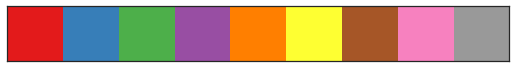

In [56]:
sns.choose_colorbrewer_palette(data_type="qualitative")